# Pset 5: Ensemble Regression Analysis
Este notebook realiza un análisis exhaustivo de métodos de ensamble para la predicción de tarifas de taxi.
**Contenido:**
1.  **Carga y Preprocesamiento**: Uso de `tabla_modelado.parquet` y split temporal.
2.  **Voting Regressor**: Combinación de modelos base.
3.  **Bagging vs Pasting**: Análisis de varianza con árboles.
4.  **Boosting Benchmark**: Comparativa de AdaBoost, GBDT, XGBoost, LightGBM y CatBoost.
5.  **Optimización**: Tuning de hiperparámetros.
6.  **Diagnóstico**: Análisis de errores y explicabilidad (SHAP).

In [5]:
# Instalación de librerías necesarias (si no están presentes)
# !pip install xgboost lightgbm catboost shap scikit-learn pandas numpy matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import time

from sklearn.model_selection import TimeSeriesSplit, PredefinedSplit, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor, BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor

# Boosting Libraries
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor, Pool

# Configuración
pd.set_option('display.max_columns', None)
sns.set_theme(style="whitegrid")

# Detección de Hardware
import torch
import multiprocessing

DEVICE_PARAMS = {}
try:
    if torch.cuda.is_available():
        print(f"✅ GPU Detectada: {torch.cuda.get_device_name(0)}")
        DEVICE_PARAMS['device'] = 'gpu'
    else:
        print("⚠️ GPU no detectada. Usando CPU.")
        DEVICE_PARAMS['device'] = 'cpu'
except:
    DEVICE_PARAMS['device'] = 'cpu'

N_JOBS = max(1, int(multiprocessing.cpu_count() * 0.75))
print(f"N_JOBS configurado a: {N_JOBS}")

✅ GPU Detectada: NVIDIA A100 80GB PCIe
N_JOBS configurado a: 96


In [6]:
# 1. Carga de Datos
file_path = 'tabla_modelado.parquet'
df = pd.read_parquet(file_path)

print(f"Dataset cargado: {df.shape}")
df.head()

Dataset cargado: (514464, 13)


,vendor_name,passenger_count,trip_distance,rate_code_desc,total_amount,service_type,pickup_dow,pickup_month,pickup_year,pickup_hour,is_weekend,is_rush_hour,pickup_borough
0,"Curb Mobility, LLC",1.0,0.84,Standard rate,11.16,yellow,7,7,2022,17,True,True,Manhattan
1,"Curb Mobility, LLC",1.0,0.47,Standard rate,8.30,yellow,6,7,2022,15,False,False,Manhattan
2,"Curb Mobility, LLC",1.0,1.59,Standard rate,14.30,yellow,4,3,2022,14,False,False,Manhattan
3,"Curb Mobility, LLC",1.0,2.17,Standard rate,15.96,yellow,7,11,2022,15,True,False,Manhattan
4,"Curb Mobility, LLC",1.0,1.43,Standard rate,17.16,yellow,4,4,2022,11,False,False,Manhattan


In [7]:
# 2. Preparación de Datos y Split Temporal

target = "total_amount"
# Definir features
categorical_cols = [
    'vendor_name', 'rate_code_desc', 'service_type', 
    'pickup_borough', 'is_weekend', 'is_rush_hour'
]
# Asegurar que existan
categorical_cols = [c for c in categorical_cols if c in df.columns]

# Numéricas (excluyendo target y fechas)
exclude = [target, 'pickup_datetime', 'dropoff_datetime', 'pickup_year']
numeric_cols = [c for c in df.columns if c not in categorical_cols + exclude]

print(f"Categóricas: {categorical_cols}")
print(f"Numéricas: {numeric_cols}")

# Split Temporal
# Train: 2022-2023
# Val: 2024
# Test: 2025

df_train = df[df["pickup_year"].isin([2022, 2023])].copy()
df_val = df[df["pickup_year"] == 2024].copy()
df_test = df[df["pickup_year"] == 2025].copy()

X_train = df_train[categorical_cols + numeric_cols]
y_train = df_train[target]

X_val = df_val[categorical_cols + numeric_cols]
y_val = df_val[target]

X_test = df_test[categorical_cols + numeric_cols]
y_test = df_test[target]

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

# --- Preprocesamiento para Modelos Clásicos (One-Hot) ---
# Boosting modernos (CatBoost, LGBM) pueden manejar categóricas nativamente o con Ordinal,
# pero para Voting/Bagging necesitamos OneHot.

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ],
    verbose_feature_names_out=False
)

# Ajustar en Train
print("Ajustando preprocesador...")
X_train_enc = preprocessor.fit_transform(X_train)
X_val_enc = preprocessor.transform(X_val)
X_test_enc = preprocessor.transform(X_test)

# Obtener nombres de features transformadas
feature_names_enc = preprocessor.get_feature_names_out()
print(f"Features transformadas: {len(feature_names_enc)}")

Categóricas: ['vendor_name', 'rate_code_desc', 'service_type', 'pickup_borough', 'is_weekend', 'is_rush_hour']
Numéricas: ['passenger_count', 'trip_distance', 'pickup_dow', 'pickup_month', 'pickup_hour']
Train: (264755, 11), Val: (130157, 11), Test: (119552, 11)
Ajustando preprocesador...
Features transformadas: 28


In [8]:
# Función de Evaluación
results = []

def evaluate_model(model, X_tr, y_tr, X_v, y_v, name):
    start = time.time()
    model.fit(X_tr, y_tr)
    train_time = time.time() - start
    
    y_pred = model.predict(X_v)
    
    rmse = np.sqrt(mean_squared_error(y_v, y_pred))
    mae = mean_absolute_error(y_v, y_pred)
    r2 = r2_score(y_v, y_pred)
    
    print(f"[{name}] RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f} | Time: {train_time:.2f}s")
    
    results.append({
        'Model': name,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Time': train_time
    })
    return model

In [9]:
# 3. Voting Regressor
print("--- Voting Regressor ---")

# Definir modelos base
reg1 = Ridge(alpha=1.0)
reg2 = DecisionTreeRegressor(max_depth=10, random_state=42)
reg3 = LinearRegression()

# Voting
voting_reg = VotingRegressor(
    estimators=[('ridge', reg1), ('dt', reg2), ('lr', reg3)],
    n_jobs=N_JOBS
)

evaluate_model(voting_reg, X_train_enc, y_train, X_val_enc, y_val, "Voting (Ridge+DT+LR)")

--- Voting Regressor ---
[Voting (Ridge+DT+LR)] RMSE: 5.6357 | MAE: 3.9464 | R2: 0.6787 | Time: 4.18s


,estimators,"[('ridge', ...), ('dt', ...), ...]"
,weights,None
,n_jobs,96
,verbose,False
,alpha,1.0
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False


In [10]:
# 4. Bagging vs Pasting
print("\n--- Bagging vs Pasting ---")

base_tree = DecisionTreeRegressor(max_depth=15, random_state=42)

# Bagging (Bootstrap = True)
bagging = BaggingRegressor(
    estimator=base_tree,
    n_estimators=50,
    bootstrap=True,
    n_jobs=N_JOBS,
    random_state=42
)
evaluate_model(bagging, X_train_enc, y_train, X_val_enc, y_val, "Bagging (Trees)")

# Pasting (Bootstrap = False)
pasting = BaggingRegressor(
    estimator=base_tree,
    n_estimators=50,
    bootstrap=False,
    n_jobs=N_JOBS,
    random_state=42
)
evaluate_model(pasting, X_train_enc, y_train, X_val_enc, y_val, "Pasting (Trees)")


--- Bagging vs Pasting ---
[Bagging (Trees)] RMSE: 5.4338 | MAE: 3.8408 | R2: 0.7013 | Time: 6.50s
[Pasting (Trees)] RMSE: 5.8068 | MAE: 4.0686 | R2: 0.6589 | Time: 2.50s


,estimator,DecisionTreeR...ndom_state=42)
,n_estimators,50
,max_samples,1.0
,max_features,1.0
,bootstrap,False
,bootstrap_features,False
,oob_score,False
,warm_start,False
,n_jobs,96
,random_state,42
,verbose,0


In [11]:
# 5. Boosting Comparison & Tuning
print("\n--- Boosting Comparison ---")

# Configurar PredefinedSplit para GridSearchCV
# Usamos Train para entrenar y Val para validar en el GridSearch
# Concatenamos para pasar a GridSearchCV
X_combined_enc = np.vstack((X_train_enc, X_val_enc))
y_combined = np.concatenate((y_train, y_val))

# Indices: -1 para train (ignorar en validación), 0 para validación
test_fold = [-1]*len(X_train) + [0]*len(X_val)
ps = PredefinedSplit(test_fold)

# --- A. AdaBoost ---
ada = AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=5), random_state=42)
param_ada = {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1]}
grid_ada = GridSearchCV(ada, param_ada, cv=ps, scoring='neg_root_mean_squared_error', n_jobs=N_JOBS)
print("Tuning AdaBoost...")
grid_ada.fit(X_combined_enc, y_combined)
evaluate_model(grid_ada.best_estimator_, X_train_enc, y_train, X_val_enc, y_val, "AdaBoost (Tuned)")

# --- B. Gradient Boosting (Sklearn) ---
gbdt = GradientBoostingRegressor(random_state=42)
param_gbdt = {'n_estimators': [100], 'learning_rate': [0.1], 'max_depth': [5]} # Reducido por tiempo
grid_gbdt = GridSearchCV(gbdt, param_gbdt, cv=ps, scoring='neg_root_mean_squared_error', n_jobs=N_JOBS)
print("Tuning GBDT...")
grid_gbdt.fit(X_combined_enc, y_combined)
evaluate_model(grid_gbdt.best_estimator_, X_train_enc, y_train, X_val_enc, y_val, "GBDT (Tuned)")

# --- C. XGBoost ---
xgb_model = xgb.XGBRegressor(random_state=42, tree_method='hist', device=DEVICE_PARAMS['device'])
param_xgb = {'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1], 'max_depth': [6]}
grid_xgb = GridSearchCV(xgb_model, param_xgb, cv=ps, scoring='neg_root_mean_squared_error', n_jobs=N_JOBS)
print("Tuning XGBoost...")
grid_xgb.fit(X_combined_enc, y_combined)
evaluate_model(grid_xgb.best_estimator_, X_train_enc, y_train, X_val_enc, y_val, "XGBoost (Tuned)")

# --- D. LightGBM ---
lgbm = lgb.LGBMRegressor(random_state=42, device=DEVICE_PARAMS['device'], verbose=-1)
param_lgbm = {'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1], 'num_leaves': [31, 63]}
grid_lgbm = GridSearchCV(lgbm, param_lgbm, cv=ps, scoring='neg_root_mean_squared_error', n_jobs=N_JOBS)
print("Tuning LightGBM...")
grid_lgbm.fit(X_combined_enc, y_combined)
evaluate_model(grid_lgbm.best_estimator_, X_train_enc, y_train, X_val_enc, y_val, "LightGBM (Tuned)")

# --- E. CatBoost (Nativo) ---
# Para CatBoost usamos el dataset original sin OneHot para aprovechar su manejo de categóricas
# Concatenamos DataFrames originales
X_combined_raw = pd.concat([X_train, X_val], axis=0).reset_index(drop=True)
y_combined_raw = pd.concat([y_train, y_val], axis=0).reset_index(drop=True)
ps_raw = PredefinedSplit(test_fold)

cat = CatBoostRegressor(
    random_seed=42, 
    verbose=0, 
    cat_features=categorical_cols,
    task_type="GPU" if DEVICE_PARAMS['device'] == 'gpu' else "CPU"
)
param_cat = {'iterations': [200, 500], 'learning_rate': [0.05, 0.1], 'depth': [6, 8]}
grid_cat = GridSearchCV(cat, param_cat, cv=ps_raw, scoring='neg_root_mean_squared_error', n_jobs=1) # CatBoost paraleliza interno
print("Tuning CatBoost...")
grid_cat.fit(X_combined_raw, y_combined_raw)

# Evaluar CatBoost (usando datos raw)
best_cat = grid_cat.best_estimator_
start = time.time()
# Ya está entrenado en el best_estimator_ con todo el dataset? No, GridSearchCV refit=True entrena en todo X_combined.
# Pero queremos evaluar en Val. Mejor re-entrenar solo en Train con mejores params para comparar justamente.
best_cat_final = CatBoostRegressor(**grid_cat.best_params_, random_seed=42, verbose=0, cat_features=categorical_cols, task_type="GPU" if DEVICE_PARAMS['device'] == 'gpu' else "CPU")
best_cat_final.fit(X_train, y_train)
train_time = time.time() - start
y_pred_cat = best_cat_final.predict(X_val)
rmse_cat = np.sqrt(mean_squared_error(y_val, y_pred_cat))
mae_cat = mean_absolute_error(y_val, y_pred_cat)
r2_cat = r2_score(y_val, y_pred_cat)

print(f"[CatBoost (Tuned)] RMSE: {rmse_cat:.4f} | MAE: {mae_cat:.4f} | R2: {r2_cat:.4f} | Time: {train_time:.2f}s")
results.append({'Model': 'CatBoost (Tuned)', 'RMSE': rmse_cat, 'MAE': mae_cat, 'R2': r2_cat, 'Time': train_time})


--- Boosting Comparison ---
Tuning AdaBoost...
[AdaBoost (Tuned)] RMSE: 5.1813 | MAE: 3.6229 | R2: 0.7284 | Time: 56.32s
Tuning GBDT...
[GBDT (Tuned)] RMSE: 5.3950 | MAE: 3.8075 | R2: 0.7056 | Time: 45.65s
Tuning XGBoost...


/home/dchicaiza/Pset-5/.venv/lib/python3.10/site-packages/xgboost/core.py:774: UserWarning: [00:19:21] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
/home/dchicaiza/Pset-5/.venv/lib/python3.10/site-packages/xgboost/core.py:774: UserWarning: [00:19:25] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.

[XGBoost (Tuned)] RMSE: 5.3595 | MAE: 3.7928 | R2: 0.7094 | Time: 0.52s
Tuning LightGBM...


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning gen

[LightGBM (Tuned)] RMSE: 5.3611 | MAE: 3.7947 | R2: 0.7092 | Time: 1.45s
Tuning CatBoost...
[CatBoost (Tuned)] RMSE: 5.3499 | MAE: 3.7851 | R2: 0.7105 | Time: 9.22s


In [12]:
# 6. Selección del Mejor Modelo
results_df = pd.DataFrame(results).sort_values(by='RMSE')
print("\n--- Resultados Finales (Validación) ---")
print(results_df)

best_model_name = results_df.iloc[0]['Model']
print(f"\n🏆 Mejor Modelo: {best_model_name}")

# Seleccionar objeto del mejor modelo
if "CatBoost" in best_model_name:
    final_model = best_cat_final
    X_test_final = X_test
    X_val_final = X_val
else:
    # Mapear nombre a objeto (simplificado)
    if "XGBoost" in best_model_name: final_model = grid_xgb.best_estimator_
    elif "LightGBM" in best_model_name: final_model = grid_lgbm.best_estimator_
    elif "AdaBoost" in best_model_name: final_model = grid_ada.best_estimator_
    elif "GBDT" in best_model_name: final_model = grid_gbdt.best_estimator_
    elif "Bagging" in best_model_name: final_model = bagging
    elif "Pasting" in best_model_name: final_model = pasting
    elif "Voting" in best_model_name: final_model = voting_reg
    
    X_test_final = X_test_enc
    X_val_final = X_val_enc

# Evaluación en Test
y_test_pred = final_model.predict(X_test_final)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"\n--- Evaluación Final en TEST (2025) ---")
print(f"RMSE: {test_rmse:.4f}")
print(f"MAE:  {test_mae:.4f}")
print(f"R2:   {test_r2:.4f}")


--- Resultados Finales (Validación) ---
                  Model      RMSE       MAE        R2       Time
3      AdaBoost (Tuned)  5.181291  3.622945  0.728425  56.323623
7      CatBoost (Tuned)  5.349903  3.785082  0.710462   9.217054
5       XGBoost (Tuned)  5.359535  3.792766  0.709419   0.523388
6      LightGBM (Tuned)  5.361130  3.794682  0.709246   1.453384
4          GBDT (Tuned)  5.394951  3.807541  0.705566  45.651328
1       Bagging (Trees)  5.433805  3.840780  0.701309   6.504824
0  Voting (Ridge+DT+LR)  5.635709  3.946397  0.678700   4.184059
2       Pasting (Trees)  5.806801  4.068573  0.658896   2.503427

🏆 Mejor Modelo: AdaBoost (Tuned)

--- Evaluación Final en TEST (2025) ---
RMSE: 5.3054
MAE:  3.7738
R2:   0.7090


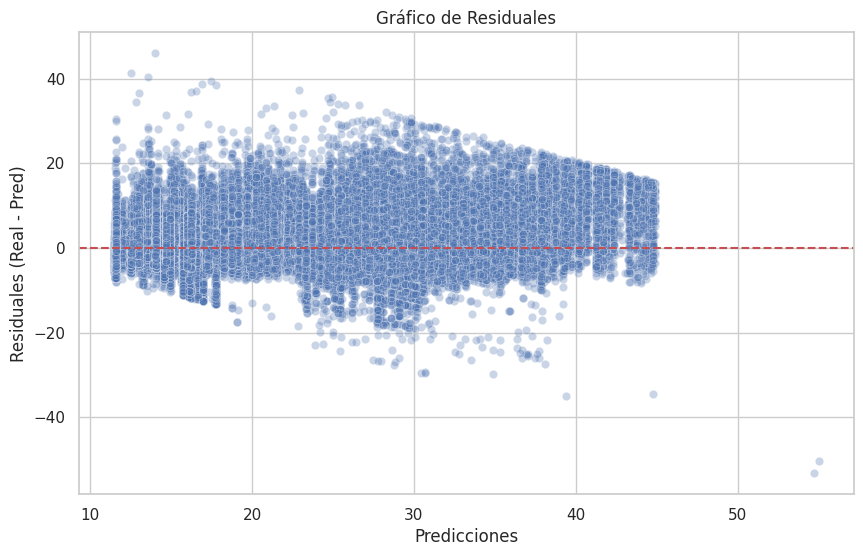

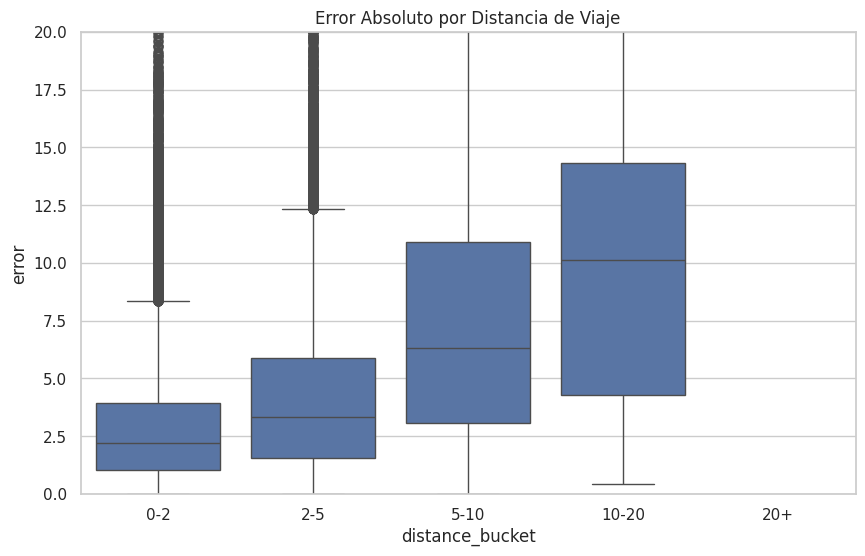

/home/dchicaiza/Pset-5/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but AdaBoostRegressor was fitted without feature names
  warnings.warn(
/home/dchicaiza/Pset-5/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but AdaBoostRegressor was fitted without feature names
  warnings.warn(
/home/dchicaiza/Pset-5/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but AdaBoostRegressor was fitted without feature names
  warnings.warn(
/home/dchicaiza/Pset-5/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but AdaBoostRegressor was fitted without feature names
  warnings.warn(
/home/dchicaiza/Pset-5/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but AdaBoostRegressor was fitted without feature names
  warnings.warn(
/home/dchi

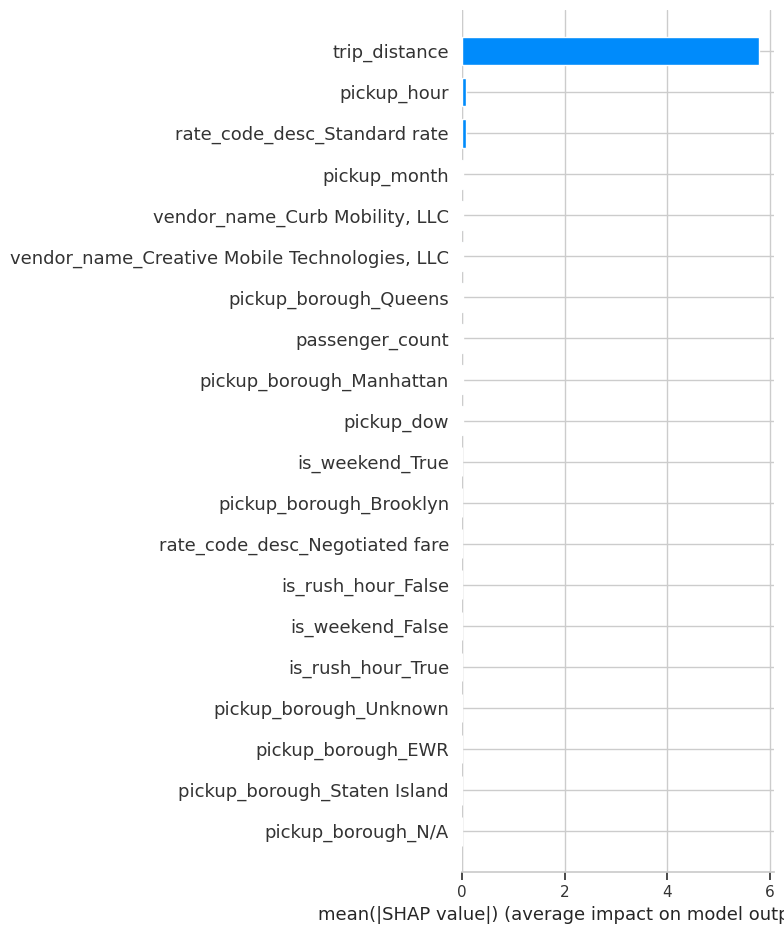

In [13]:
# 7. Diagnósticos

# A. Residuales
residuals = y_test - y_test_pred
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_pred, y=residuals, alpha=0.3)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicciones')
plt.ylabel('Residuales (Real - Pred)')
plt.title('Gráfico de Residuales')
plt.show()

# B. Error por Buckets (Distancia)
df_test['error'] = np.abs(residuals)
df_test['distance_bucket'] = pd.cut(df_test['trip_distance'], bins=[0, 2, 5, 10, 20, 100], labels=['0-2', '2-5', '5-10', '10-20', '20+'])

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_test, x='distance_bucket', y='error')
plt.title('Error Absoluto por Distancia de Viaje')
plt.ylim(0, 20) # Limitar para ver mejor la distribución
plt.show()

# C. Feature Importance (SHAP)
# Usamos una muestra del test set para SHAP porque es costoso
X_shap_sample = X_test_final[:500] # Muestra pequeña
if isinstance(X_shap_sample, pd.DataFrame):
    pass # Ya es DF
else:
    # Si es numpy array (OneHot), convertir a DF para nombres
    X_shap_sample = pd.DataFrame(X_shap_sample.toarray() if hasattr(X_shap_sample, 'toarray') else X_shap_sample, columns=feature_names_enc)

explainer = shap.Explainer(final_model.predict, X_shap_sample)
shap_values = explainer(X_shap_sample)

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_shap_sample, plot_type="bar")
plt.show()